# Feature Engineering

## 환경 설정 [😉 이 코드는 반드시 실행하세요! 😉]
> 만약 구글 드라이브 마운트(Google Drive Mount)가 안되어있다면 꼭 마운트를 하고나서 진행한다! 
- 패키지 설치 및 임포트
- **실습을 위한 폴더 경로 설정** <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄


### A. 패키지 설치 및 임포트

In [ ]:
!pip install -q -U PyYAML
!pip install -q -U scikit-learn==1.1.3
!pip install -q joblib==1.1.0
!pip install -q shap eli5 cairosvg jupyter_contrib_nbextensions mglearn category_encoders

In [ ]:
import os
import gc
import time
import itertools
import random

from collections import OrderedDict, defaultdict
from abc import *

# 설정
from datetime import datetime

import yaml
import glob
import shutil

# Log
import logging

# I/O
from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# 공학용 연산
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import pprint
pp = pprint.PrettyPrinter(indent=1)

# 머신러닝
import lightgbm as lgb

import mglearn

# 딥러닝
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import warnings

# warning을 보고 싶지 않을 경우 아래 코드 활성화
# warnings.filterwarnings('ignore')

### B. 실습을 위한 폴더 경로 설정 <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄

In [ ]:
# 이 실습 파일이 위치하고 있는 경로!
# 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄
PROJECT_PATH = "drive/MyDrive/AI 부스트캠프/프로젝트"

In [ ]:
# 실습을 위한 data 폴더 생성
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)


## 🛠️ 특성 공학 (Feature Engineering)

- 도메인 지식 (Domain Knowledge)
- 메모리 (Memory)
- 통계량 (Statistics)
- 날짜와 시간 (Datetime)
- 이산화 (Binning)
- 상호작용 (Interaction)
- 행렬 분해 (Matrix Factorization)
- 차원 축소 (Dimension Reduction)
- 임베딩 (Embedding)
- 외부 데이터 활용 (Data Enrichment)


**도메인 지식(Domain Knowledge)를 활용하여 ML 모델의 예측에 도움이 되는 새로운 feature를 만드는 방법이다**

> 해당 분야에서의 우리의 경험을 활용하여 예측에 유용한 feature를 만드는 과정으로, 탐정이 현장에서 주어진 단서들을 바탕으로 추리를 통해 새로운 인사이트를 찾아내는 과정과 유사하다. 이런 새로운 인사이트가 주어지면 최종 범인이 누구인지 특정하기가 더욱 수월해진다. 우리의 경험과 지식을 데이터에 포함시켜 모델이 더욱 쉽게 배울 수 있도록 도와주는 과정으로 생각할 수 있다.  
- 단서 : feature
- 추리 : feature engineering

**⛔ 상세 예시 설명 ⛔**
> **특성 공학(Feature Engineering)에는 정답이 없다.** 어떤 도메인(domain)의 문제를 푸느냐에 따라 접근법도 상이하며 같은 도메인(domain)이더라도 데이터셋이 다르면 만드는 feature들도 달라진다. 그렇기 때문에 **이 섹션에서 제공되는 상세 예시들은 이 섹션에서 사용하는 데이터셋에 맞춰 제작되었으며 다른 섹션들과 다르게 보편적으로 활용할 수 없으니 참고용으로 사용하자.** 


**유용한 자료**
- [Feature Engineering - Wikipedia](https://en.wikipedia.org/wiki/Feature_engineering)
- [Discover Feature Engineering, How to Engineer Features and How to Get Good at It - MachineLeariningMastery](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
- [Feature Engineering Using Pandas for Beginners - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/12/feature-engineering-using-pandas-for-beginners/)
- [GroupBy in Pandas: Your Guide to Summarizing and Aggregating Data in Python - Analytics Vidhya](https://medium.com/analytics-vidhya/groupby-in-pandas-your-guide-to-summarizing-and-aggregating-data-in-python-4b702405c440)
- [feature templates - Stanford cs221](https://stanford-cs221.github.io/autumn2020-extra/modules/machine-learning/feature-templates.pdf)

In [ ]:
# 실습을 위한 순서 데이터(Sequence Data)
# user - 사용자
# content - 문제
# time - 문제를 푸는데 걸린 시간 (초, sec)
# time - 문제를 푼 시간 (ex: 2021-01-20 10:24:34)
# correct - 문제 정답 여부

np.random.seed(7)

edu_df = pd.DataFrame({'user': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C', 'C'],
                       'content': ['1', '2', '3', '1', '2', '1', '1', '1', '2', '1', '1', '1'],
                       'time': [22, 19, 27, 15, 11, 33, 10, 30, 40, 35, 12, 5],
                       'timestamp': sorted([pd.Timestamp(2021, 1, np.random.randint(1, 30), np.random.randint(10, 15), 30, 7).timestamp() for _ in range(12)]),
                       'correct': [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]})
edu_df

,user,content,time,timestamp,correct
0,A,1,22,1.609508e+09,1
1,A,2,19,1.610026e+09,0
2,A,3,27,1.610116e+09,1
3,A,1,15,1.610807e+09,1
4,A,2,11,1.610894e+09,1
5,B,1,33,1.611153e+09,0
6,B,1,10,1.611491e+09,1
7,C,1,30,1.611657e+09,0
8,C,2,40,1.611664e+09,1
9,C,1,35,1.611668e+09,1


- https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/209892
- https://featuretools.alteryx.com/en/stable/
- https://www.analyticsvidhya.com/blog/2020/10/7-feature-engineering-techniques-machine-learning/
- https://elitedatascience.com/feature-engineering

### 🔨 도메인 지식 (Domain Knowledge)

> 각 도메인마다 전문가의 의견 청취 혹은 자신의 경험을 바탕으로 자주 나타나는 패턴을 알고 있는 경우 이러한 선험적 지식(Prior Knowledge)을 feature를 만드는데 활용할 수 있다.

**교육 측면에서 생각해볼 수 있는 예시**
- 학생이 답안지를 한 줄로 찍은 경우 판별
- 중간에 강의를 보고 같은 문제를 푸는 경우
- 모르는 문제를 만났을 경우 학생의 찍는 경향
- 문제의 난이도 판정
- 학생의 지식 수준 판정

###🔨 메모리 (Memory)

> 순서 데이터(Sequence Data)가 주어질 경우 순서 모델(Sequence Model, [ex: LSTM, Transformer, etc])을 사용하며 이 모델은 메모리(Memory)를 내장하고 있어 이전/이후에 입력된 데이터들을 기억하고 참조한다. 
<br><br>
주어진 데이터 이전/이후의 데이터들을 포함하는 **메모리(Memory)를 feature로 포함**시킴으로서 순서 모델(Sequence Model)를 사용하지 않고 일반적인 지도 학습 모델(ex: Light GBM, NN)을 사용하여 훈련할 수 있다.

1. 이동 (Shift)
2. 누적 합 (Cumsum)
3. 누적 총계 (Cumcount)
4. 이동 평균 (Rolling Mean)

**유용한 자료**
- [How to Convert a Time Series to a Supervised Learning Problem in Python - MachineLearningMastery](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

#### 1. 이동 (Shift)

> 데이터를 이동시켜 미래 혹은 과거의 데이터들을 feature로 포함시킬 수 있다. 미래/과거의 데이터들이 현재를 판단할 때 중요할 경우 사용한다. `groupby`를 사용할 경우 각 그룹(group)별로 데이터를 이동(shift)시키는 것이 가능하다. shift를 사용할 경우 데이터가 이동하므로 비어있는 곳에 `NaN`이 들어간다.

- 미래/과거의 특정 시점에 문제 정답 맞춤 여부


- [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- [pandas.DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)

##### 미래/과거의 특정 시점에 문제 정답 맞춤 여부

> **이동(shift)**를 이용하여 유저별로 미래/과거의 특정 시점에 문제 정답을 맞췄는지 못 맞췄는지에 대한 여부를 feature로 추가해보자. 

In [ ]:
edu_shift_df = edu_df.copy()

# 미래 정보
edu_shift_df['correct_shift_-2'] = edu_shift_df.groupby('user')['correct'].shift(-2)
edu_shift_df['correct_shift_-1'] = edu_shift_df.groupby('user')['correct'].shift(-1)

# 과거 정보
edu_shift_df['correct_shift_1'] = edu_shift_df.groupby('user')['correct'].shift(1)
edu_shift_df['correct_shift_2'] = edu_shift_df.groupby('user')['correct'].shift(2)

edu_shift_df.iloc[:, [0, 3, 4, 5, 6, 7]]

,user,timestamp,correct,correct_shift_-2,correct_shift_-1,correct_shift_1
0,A,1.609508e+09,1,1.0,0.0,NaN
1,A,1.610026e+09,0,1.0,1.0,1.0
2,A,1.610116e+09,1,1.0,1.0,0.0
3,A,1.610807e+09,1,NaN,1.0,1.0
4,A,1.610894e+09,1,NaN,NaN,1.0
5,B,1.611153e+09,0,NaN,1.0,NaN
6,B,1.611491e+09,1,NaN,NaN,0.0
7,C,1.611657e+09,0,1.0,1.0,NaN
8,C,1.611664e+09,1,1.0,1.0,0.0
9,C,1.611668e+09,1,1.0,1.0,1.0


#### 2. 누적 합 (Cumsum)

> 이동(shift)만 사용하면 참조할 수 있는 미래/과거 데이터들의 갯수가 제한되며 참조하는 갯수에 따라 추가되는 feature의 수가 크게 늘어난다. 이 경우 미래/과거 데이터들을 모두 더하여 한 개의 feature에 포함시킬 수 있다. 이때 누적합(cumsum)을 사용한다

- 문제 풀이에 사용한 총 시간
- 과거에 맞춘 문제 수
- 미래에 맞출 문제 수
- 과거에 해당 문제를 맞춘 횟수


- [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- [pandas.DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)
- [pandas.DataFrame.cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html)

##### 문제 풀이에 사용한 총 시간

> **누적합(cumsum)**을 이용하여 유저별로 문제풀이에 사용한 총 시간을 feature로 추가해보자. 

In [ ]:
edu_cumsum_df = edu_df.copy()

# 문제 풀이에 총 사용 시간 
edu_cumsum_df['total_used_time'] = edu_cumsum_df.groupby('user')['time'].cumsum()

edu_cumsum_df[['user', 'time', 'total_used_time']]

,user,time,total_used_time
0,A,22,22
1,A,19,41
2,A,27,68
3,A,15,83
4,A,11,94
5,B,33,33
6,B,10,43
7,C,30,30
8,C,40,70
9,C,35,105


##### 과거에 맞춘 문제 수

> **이동(Shift)와 누적합(cumsum)**을 사용하여 유저별 과거에 맞춘 문제 수를 feature로 추가해보자.

In [ ]:
edu_correct_df = edu_df.copy()

# 과거에 맞춘 문제 수 
edu_correct_df['shift'] = edu_correct_df.groupby('user')['correct'].shift().fillna(0)
edu_correct_df['past_correct'] = edu_correct_df.groupby('user')['shift'].cumsum()

edu_correct_df[['user', 'correct', 'past_correct']]

,user,correct,past_correct
0,A,1,0.0
1,A,0,1.0
2,A,1,1.0
3,A,1,2.0
4,A,1,3.0
5,B,0,0.0
6,B,1,0.0
7,C,0,0.0
8,C,1,0.0
9,C,1,1.0


##### 미래에 맞출 문제 수

> **이동(Shift)와 누적합(cumsum)**을 사용하여 유저별 미래에 맞출 문제 수를 feature로 추가해보자.

In [ ]:
reversed_edu_correct_df = edu_df.iloc[::-1].copy()

# 미래에 맞출 문제 수
reversed_edu_correct_df['shift'] = reversed_edu_correct_df.groupby('user')['correct'].shift().fillna(0)
reversed_edu_correct_df['future_correct'] = reversed_edu_correct_df.groupby('user')['shift'].cumsum()
edu_correct_df = reversed_edu_correct_df.iloc[::-1]

edu_correct_df[['user', 'correct', 'future_correct']]

,user,correct,future_correct
0,A,1,3.0
1,A,0,3.0
2,A,1,2.0
3,A,1,1.0
4,A,1,0.0
5,B,0,1.0
6,B,1,0.0
7,C,0,4.0
8,C,1,3.0
9,C,1,2.0


##### 과거에 해당 문제를 맞춘 횟수

> **이동(Shift)와 누적합(cumsum)**을 사용하여 유저별 **현재 풀고 있는 문제를 과거에 맞춘 횟수**를 feature로 추가해보자. 유저가 해당 문제를 과거에 풀었다면 다시 마주할 경우 더욱 쉽게 풀 것이라는 가정이 깔려있다.

In [ ]:
edu_correct_df = edu_df.copy()

# 과거에 해당 문제를 맞춘 횟수
edu_correct_df['shift'] = edu_correct_df.groupby(['user', 'content'])['correct'].shift().fillna(0)
edu_correct_df['past_content_correct'] = edu_correct_df.groupby(['user', 'content'])['shift'].cumsum()

edu_correct_df[['user', 'content', 'correct', 'past_content_correct']]

,user,content,correct,past_content_correct
0,A,1,1,0.0
1,A,2,0,0.0
2,A,3,1,0.0
3,A,1,1,1.0
4,A,2,1,0.0
5,B,1,0,0.0
6,B,1,1,0.0
7,C,1,0,0.0
8,C,2,1,0.0
9,C,1,1,0.0


#### 3. 누적 총계 (Cumcount)

> 누적합(cumsum)을 이용하여 미래/과거 데이터들을 갯수 제한 없이 포함시켰다. 다만 이는 정규화(normalize)가 되지 않아 과거/미래 데이터가 누적될수록 값이 제한없이 커지게 된다. 이때 누적 총계(cumcount)를 이용하여 나누는 방법이 있으며 그 결과로 평균(average)값을 구할 수 있다.

- 과거에 푼 문제 수
- 과거 평균 정답률
- 과거에 해당 문제 평균 정답률


- [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- [pandas.DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)
- [pandas.DataFrame.cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html)
- [pandas.core.groupby.GroupBy.cumcount](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.cumcount.html)

##### 과거에 푼 문제 수

> **누적총계(cumcount)**를 사용하여 유저별 과거에 푼 문제수를 feature로 추가해보자.

In [ ]:
edu_correct_df = edu_df.copy()

# 과거에 푼 문제 수
edu_correct_df['past_count'] = edu_correct_df.groupby('user').cumcount()


edu_correct_df[['user', 'correct', 'past_count']]

,user,correct,past_count
0,A,1,0
1,A,0,1
2,A,1,2
3,A,1,3
4,A,1,4
5,B,0,0
6,B,1,1
7,C,0,0
8,C,1,1
9,C,1,2


##### 과거 평균 정답률

> **이동(Shift), 누적합(cumsum)와 누적총계(cumcount)**를 사용하여 유저별 과거 평균 정답률을 feature로 추가해보자.

**다음의 2가지 feature를 만든 후 이를 나눈다.**
- 과거에 맞춘 문제 수
- 과거에 푼 문제 수

과거 평균 정답률 $=$ 과거에 맞춘 문제 수 $\div$ 과거에 푼 문제 수

In [ ]:
edu_correct_df = edu_df.copy()

# 과거에 푼 문제 수
edu_correct_df['past_count'] = edu_correct_df.groupby('user').cumcount()

# 과거에 맞춘 문제 수
edu_correct_df['shift'] = edu_correct_df.groupby('user')['correct'].shift().fillna(0)
edu_correct_df['past_correct'] = edu_correct_df.groupby('user')['shift'].cumsum()

# 과거 평균 정답률
edu_correct_df['average_correct'] = (edu_correct_df['past_correct'] / edu_correct_df['past_count']).fillna(0)

edu_correct_df[['user', 'correct', 'average_correct']]

,user,correct,average_correct
0,A,1,0.000000
1,A,0,1.000000
2,A,1,0.500000
3,A,1,0.666667
4,A,1,0.750000
5,B,0,0.000000
6,B,1,0.000000
7,C,0,0.000000
8,C,1,0.000000
9,C,1,0.500000


##### 과거 해당 문제 평균 정답률

> **이동(Shift), 누적합(cumsum)와 누적총계(cumcount)**를 사용하여 유저별 **현재 풀고 있는 문제의 과거 평균 정답률**을 feature로 추가해보자.

**다음의 2가지 feature를 만든 후 이를 나눈다.**
- 과거에 해당 문제를 맞춘 수
- 과거에 해당 문제를 푼 수

과거 해당 문제 평균 정답률 $=$ 과거에 해당 문제를 맞춘 수 $\div$ 과거에 해당 문제를 푼 수

In [ ]:
edu_correct_df = edu_df.copy()

# 과거에 해당 문제를 푼 수
edu_correct_df['past_content_count'] = edu_correct_df.groupby(['user', 'content']).cumcount()

# 과거에 해당 문제를 맞춘 수
edu_correct_df['shift'] = edu_correct_df.groupby(['user', 'content'])['correct'].shift().fillna(0)
edu_correct_df['past_content_correct'] = edu_correct_df.groupby(['user', 'content'])['shift'].cumsum()

# 과거 해당 문제 평균 정답률
edu_correct_df['average_content_correct'] = (edu_correct_df['past_content_correct'] / edu_correct_df['past_content_count']).fillna(0)

edu_correct_df[['user', 'content', 'correct', 'average_content_correct']]

,user,content,correct,average_content_correct
0,A,1,1,0.000000
1,A,2,0,0.000000
2,A,3,1,0.000000
3,A,1,1,1.000000
4,A,2,1,0.000000
5,B,1,0,0.000000
6,B,1,1,0.000000
7,C,1,0,0.000000
8,C,2,1,0.000000
9,C,1,1,0.000000


#### 4. 이동 평균 (Rolling Mean)

> 위에서 평균을 구했을 때 모든 미래/과거의 데이터들을 이용하여 평균을 구하였다. 만약 현재 데이터를 중심으로 제한된 범위의 과거 데이터를 이용해서 평균을 구하고 싶을 때 이동 평균(Rolling Mean)을 사용할 수 있다.

- 최근 3개 문제 평균 풀이 시간


- [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- [pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

##### 최근 3개 문제 평균 풀이 시간

> **이동 평균(Rolling Mean)**을 사용해 현재 푸는 문제를 포함해서 최근 3개 문제의 평균 풀이 시간을 feature로 추가해보자. 최근 문제를 얼마나 빨리 푸느냐에 따라 학생의 최근 컨디션을 추측해볼 수 있을지도 모른다.

In [ ]:
edu_rolling_df = edu_df.copy()

# 최근 3개 문제 평균 풀이 시간
edu_rolling_df['mean_time'] = edu_rolling_df.groupby(['user'])['time'].rolling(3).mean().values

edu_rolling_df[['user', 'time', 'mean_time']]

,user,time,mean_time
0,A,22,NaN
1,A,19,NaN
2,A,27,22.666667
3,A,15,20.333333
4,A,11,17.666667
5,B,33,NaN
6,B,10,NaN
7,C,30,NaN
8,C,40,NaN
9,C,35,35.000000


### 🔨 통계량 (Statistics)

> 가장 보편적으로 많이 사용되는 방법으로 feature를 그룹으로 묶어 각 그룹의 통계량(statistics)을 feature로 추가하는 방법이다. 정형 데이터(structured data)를 사용하는 대회에서 매우 자주 볼 수 있다.

1. 수치형 feature의 평균과 표준편차
2. 문제 풀이에 사용한 시간의 중간값


- [pandas.DataFrame.agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)




#### 1. 수치형 feature의 평균과 표준편차

> 데이터셋의 모든 수치형 feature의 유저별 평균(mean)과 표준편차(standard deviation)을 새로운 feature로 추가해보자.

In [ ]:
edu_agg_df = edu_df.copy()

# 평균 (mean) / 표준 편차 (std)
agg_df = edu_agg_df.groupby('user').agg(['mean', 'std'])

# mapping을 위해 pandas DataFrame을 dictionary형태로 변환
agg_dict = agg_df.to_dict()

# 구한 통계량을 각 사용자에게 mapping
for k, v in agg_dict.items():
    # feature 이름
    feature_name = "_".join(k)
    
    # mapping이후 새로운 feature 추가
    edu_agg_df[feature_name] = edu_agg_df['user'].map(v)

edu_agg_df

,user,content,time,timestamp,correct,content_mean,content_std,time_mean,time_std,timestamp_mean,timestamp_std,correct_mean,correct_std
0,A,1,22,1.609508e+09,1,2462.4,0.836660,18.8,6.180615,1.610270e+09,579216.394796,0.8,0.447214
1,A,2,19,1.610026e+09,0,2462.4,0.836660,18.8,6.180615,1.610270e+09,579216.394796,0.8,0.447214
2,A,3,27,1.610116e+09,1,2462.4,0.836660,18.8,6.180615,1.610270e+09,579216.394796,0.8,0.447214
3,A,1,15,1.610807e+09,1,2462.4,0.836660,18.8,6.180615,1.610270e+09,579216.394796,0.8,0.447214
4,A,2,11,1.610894e+09,1,2462.4,0.836660,18.8,6.180615,1.610270e+09,579216.394796,0.8,0.447214
5,B,1,33,1.611153e+09,0,5.5,0.000000,21.5,16.263456,1.611322e+09,239284.934754,0.5,0.707107
6,B,1,10,1.611491e+09,1,5.5,0.000000,21.5,16.263456,1.611322e+09,239284.934754,0.5,0.707107
7,C,1,30,1.611657e+09,0,2422.2,0.447214,24.4,15.142655,1.611733e+09,116096.511575,0.8,0.447214
8,C,2,40,1.611664e+09,1,2422.2,0.447214,24.4,15.142655,1.611733e+09,116096.511575,0.8,0.447214
9,C,1,35,1.611668e+09,1,2422.2,0.447214,24.4,15.142655,1.611733e+09,116096.511575,0.8,0.447214


#### 2. 문제 풀이에 사용한 시간의 중간값

> 유저별 문제 풀이에 사용한 시간의 중간값을 feature로 추가해보자. 이 경우 각 문제를 풀 때 상대적으로 빨리 풀었는지 늦게 풀었는지 알 수 있다. 상대적인 풀이 시간 비교를 통해 해당 사용자가 문제를 쉽게 느끼는지 어렵게 느끼는지 추론해 볼 수 있을지도 모른다.

In [ ]:
edu_agg_df = edu_df.copy()

# 중간값 (median)
agg_df = edu_agg_df.groupby('user')['time'].agg(['median'])

# mapping을 위해 pandas DataFrame을 dictionary형태로 변환
agg_dict = agg_df.to_dict()

# 구한 통계량을 각 사용자에게 mapping
edu_agg_df['time_median'] = edu_agg_df['user'].map(agg_dict['median'])

edu_agg_df[['user', 'time', 'time_median']]

,user,time,time_median
0,A,22,19.0
1,A,19,19.0
2,A,27,19.0
3,A,15,19.0
4,A,11,19.0
5,B,33,21.5
6,B,10,21.5
7,C,30,30.0
8,C,40,30.0
9,C,35,30.0


### 🔨 날짜와 시간 (Datetime)

> 날짜와 시간(datetime)이 존재하는 데이터셋에서는 이를 활용하여 다양한 feature를 만들어낼 수 있다. 날짜와 시간을 다른 feature들과 엮어서 어떤 feature를 만들어낼 수 있을지 자유롭게 상상력을 발휘해보자.

- 문제를 푸는 시간대
- 시간대별 정답률
- 사용자의 야행성 여부
- 문제 풀이 시간 정규화
- 문제 풀이에 사용한 시간의 상대적 비교

**유용한 자료**
- [6 Powerful Feature Engineering Techniques For Time Series Data (using Python) - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/)


##### 문제를 푸는 시간대

> 유저가 문제를 몇 시에 푸는지를 feature로 추가해보자. 여기서 더 응용한다면 특정 시간대의 문제 정답률을 확인해봄으로서 특정 시간대의 사용자들의 능률을 알 수 있을지도 모른다.

- [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
- [pandas.DataFrame.transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)

In [ ]:
edu_time_df = edu_df.copy()

# custom 함수 적용
edu_time_df['hour'] = edu_time_df['timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

edu_time_df[['user', 'timestamp', 'hour']]

,user,timestamp,hour
0,A,1.609508e+09,13
1,A,1.610026e+09,13
2,A,1.610116e+09,14
3,A,1.610807e+09,14
4,A,1.610894e+09,14
5,B,1.611153e+09,14
6,B,1.611491e+09,12
7,C,1.611657e+09,10
8,C,1.611664e+09,12
9,C,1.611668e+09,13


##### 시간대별 정답률

> 유저 상관 없이 시간대별 정답률을 feature로 추가해보자. 특정 시간대의 정답률에서 패턴을 발견할 수 있을지도 모른다.


- [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
- [pandas.DataFrame.transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)

In [ ]:
edu_time_df = edu_df.copy()

# 문제를 푸는 시간대
edu_time_df['hour'] = edu_time_df['timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

# 시간대별 정답률
hour_dict = edu_time_df.groupby(['hour'])['correct'].mean().to_dict()
edu_time_df['correct_per_hour'] = edu_time_df['hour'].map(hour_dict)

edu_time_df.groupby(['hour'])[['correct', 'correct_per_hour']].mean()

,correct,correct_per_hour
hour,,
10,0.500000,0.500000
12,1.000000,1.000000
13,0.666667,0.666667
14,0.800000,0.800000


##### 사용자의 야행성 여부

> 사용자가 밤에 주로 활동하는 사람인지 낮에 주로 활동하는 사람인지 여부를 feature로 추가해보자. 이를 통해 사용자가 문제를 풀 때 어떤 시간대인지에 따라 효율을 추정해볼 수 있을지도 모른다.


- [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
- [pandas.DataFrame.transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)

In [ ]:
edu_time_df = edu_df.copy()

# 문제를 푸는 시간대
edu_time_df['hour'] = edu_time_df['timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

# 사용자의 주 활동 시간
mode_dict = edu_time_df.groupby(['user'])['hour'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
edu_time_df['hour_mode'] = edu_time_df['user'].map(mode_dict)

# 사용자의 야행성 여부
# 시간이 10 ~ 15시 사이에 분포되어 있어 여기에서는 임의로 12로 분리하였다
edu_time_df['is_night'] = edu_time_df['hour_mode'] > 12

edu_time_df[['user', 'hour', 'hour_mode', 'is_night']]

,user,hour,hour_mode,is_night
0,A,13,14,True
1,A,13,14,True
2,A,14,14,True
3,A,14,14,True
4,A,14,14,True
5,B,14,12,False
6,B,12,12,False
7,C,10,10,False
8,C,12,10,False
9,C,13,10,False


##### 문제 풀이 시간 정규화

> 문제 풀이에 사용한 시간을 정규화하여 feature로 추가해보자.

- [pandas.DataFrame.transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)

In [ ]:
edu_custom_df = edu_df.copy()

# custom 함수 적용
# time만 transform하였다
edu_custom_df['normalized_time'] = edu_custom_df.groupby('user')['time'].transform(lambda x: (x - x.mean())/x.std())

edu_custom_df[['user', 'time', 'normalized_time']]

,user,time,normalized_time
0,A,22,0.517748
1,A,19,0.032359
2,A,27,1.326729
3,A,15,-0.614826
4,A,11,-1.262010
5,B,33,0.707107
6,B,10,-0.707107
7,C,30,0.369816
8,C,40,1.030202
9,C,35,0.700009


##### 문제 풀이에 사용한 시간의 상대적 비교

> 문제 풀이에 사용한 시간과 이를 바탕으로 구한 중간값과의 차이를 통해 문제 풀이에 시간을 얼마나 사용하였는지를 상대적으로 비교하는 feature를 추가해보자.

- [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [ ]:
edu_custom_df = edu_df.copy()

# custom 함수 적용
# apply를 사용해 time column을 직접 지정할 수 있다
edu_custom_df['relative_time'] = edu_custom_df.groupby('user').apply(lambda x: x['time'] - x['time'].median()).values

edu_custom_df[['user', 'time', 'relative_time']]

,user,time,relative_time
0,A,22,3.0
1,A,19,0.0
2,A,27,8.0
3,A,15,-4.0
4,A,11,-8.0
5,B,33,11.5
6,B,10,-11.5
7,C,30,0.0
8,C,40,10.0
9,C,35,5.0


### 🔨 이산화 (Binning)

> 연속형 feature를 구간을 나눠 범주형 feature로 변환한다. 경우에 따라서는 범주형 feature를 대상으로 이산화(Binning)을 진행하기도 한다. 이 경우 카테고리를 더욱 적은 수의 카테고리로 재분류하는 것과 같다.

**⭐ 트리(Tree)와 회귀(Regression)에서의 이산화(Binning) ⭐**
> 트리(Tree) 모델은 이산화(Binning)를 내부적으로 해주기에 별도로 이산화(Binning)를 하지 않아도 된다. 그렇다면 회귀에서의 이산화(Binning)는 어떤 영향이 있을까? 트리와 회귀에서 이산화(Binning)가 어떤 영향을 미치는지 시각적으로 확인해보자.
- ⭐ 트리와 회귀의 이산화 비교 (Compare of Tree and Regression at Binning) ⭐


1. 문제 풀이 시간 구간으로 나누기

**유용한 자료**
- [Data Binning - Wikipedia](https://en.wikipedia.org/wiki/Data_binning)
- [Feature Engineering — deep dive into Encoding and Binning techniques - Towards Data Science](https://towardsdatascience.com/feature-engineering-deep-dive-into-encoding-and-binning-techniques-5618d55a6b38)
- [Linear Regression, Binning and Polynomial Linear Regression - medium](https://medium.com/@rishabhrjain/linear-regrsesion-binning-and-polynomial-linear-regression-3ed62f79ce0)

#### ⭐ 회귀와 트리의 이산화 비교 (Compare of Tree and Regression at Binning) ⭐


> 트리(Tree)와 회귀(Regression)에서 이산화(Binning)가 어떤 영향을 미치는지 시각적으로 확인해보자. 

- 이산화(Binning) 이전
- 이산화(Binning) 이후
- 기존 feature + 이산화(Binning) feature

**참고자료**
- [04-representing-data-feature-engineering.ipynb - Github [ introduction_to_ml_with_python ]](https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb)

##### **이산화(Binning) 이전**

- `트리(Tree)` - 이산화는 내부적으로 진행되며 Bin 갯수는 내부 알고리즘에 의해 결정된다
- `회귀(regression)` - 전체 구간에서 회귀를 진행한다

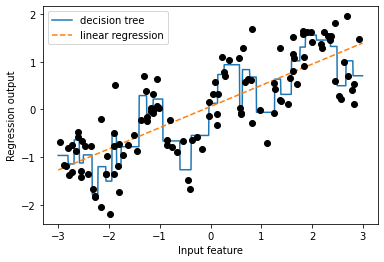

In [ ]:
# reference https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb

# Binning, Discretization, Linear Models, and Trees
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 데이터 준비
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# 모델 훈련
tree = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
reg = LinearRegression().fit(X, y)

# 시각화
plt.plot(line, tree.predict(line), label="decision tree")
plt.plot(line, reg.predict(line), '--', label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

##### **이산화(Binning) 이후**

> 회귀(Regression)와 결정 트리(Decision Tree)의 예측값이 비슷한 동향을 보임을 알 수 있다.

- `트리(Tree)` - 이산화는 동일하게 진행되나 Bin 갯수가 사용자가 직접 지정한 Bin 갯수에 맞춰진다
- `회귀(regression)` - 전체 구간에 회귀가 진행되지 않고 구간별로 회귀가 각각 진행된다


- [sklearn.preprocessing.KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html)

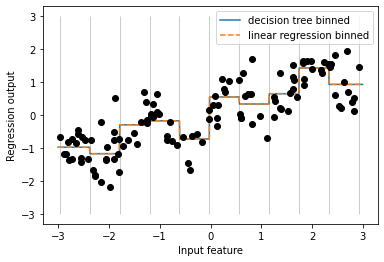

In [ ]:
# reference https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb

# Binning, Discretization, Linear Models, and Trees

from sklearn.preprocessing import KBinsDiscretizer

# 이산화 (Binning)
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)

X_binned = kb.transform(X)
line_binned = kb.transform(line)

# 모델 훈련
tree = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
reg = LinearRegression().fit(X_binned, y)

# 시각화
plt.plot(line, tree.predict(line_binned), label='decision tree binned')
plt.plot(line, reg.predict(line_binned), '--', label='linear regression binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature");

##### **기존 feature + 이산화(Binning) feature**

> 회귀(Regression)와 결정 트리(Decision Tree)의 결과는 여전히 동일하다

- `트리(Tree)` - 이산화로 나눠지는 구간이 더욱 늘어나 **overfitting되는 경향을 볼 수 있다.**
- `회귀(regression)` - 전체 구간에 회귀가 진행되지 않고 구간별로 회귀가 각각 진행되며 **기울기도 학습하기 시작한다.**


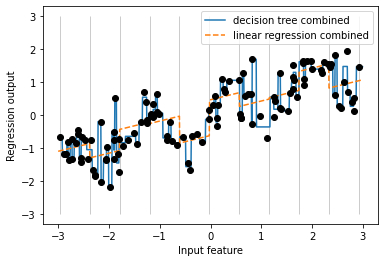

In [ ]:
# reference https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb

# Binning, Discretization, Linear Models, and Trees

X_combined = np.hstack([X, X_binned])
line_combined = np.hstack([line, line_binned])

# 이산화 (Binning) + 기존 데이터
tree = DecisionTreeRegressor(min_samples_split=3).fit(X_combined, y)
reg = LinearRegression().fit(X_combined, y)

# 모델 훈련
plt.plot(line, tree.predict(line_combined), label='decision tree combined')
plt.plot(line, reg.predict(line_combined), '--', label='linear regression combined')

# 시각화
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

#### 1. 문제 풀이 시간 구간으로 나누기

> 문제 풀이 시간을 3단계 구간으로 나누어 feature로 추가해보자. 이를 통해 문제 풀이 속도가 느린지, 평범한지, 빠른지 구분해볼 수 있을 것이다.

- [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) - feature의 최대값과 최소값의 차이를 bin 갯수만큼 나눠 구간 범위로 사용
- [pandas.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) - feature의 각 구간에 데이터 갯수가 비슷하게 배분될 수 있도록 구간을 나눔

In [ ]:
edu_time_df = edu_df.copy()

# 문제를 풀이 시간 3단계 구간으로 나누기
edu_time_df['time_cut'] = pd.cut(edu_time_df['time'], bins=3)
edu_time_df['time_qcut'] = pd.qcut(edu_time_df['time'], q=3)

edu_time_df[['time', 'time_cut', 'time_qcut']]

,time,time_cut,time_qcut
0,22,"(16.667, 28.333]","(14.0, 28.0]"
1,19,"(16.667, 28.333]","(14.0, 28.0]"
2,27,"(16.667, 28.333]","(14.0, 28.0]"
3,15,"(4.965, 16.667]","(14.0, 28.0]"
4,11,"(4.965, 16.667]","(4.999, 14.0]"
5,33,"(28.333, 40.0]","(28.0, 40.0]"
6,10,"(4.965, 16.667]","(4.999, 14.0]"
7,30,"(28.333, 40.0]","(28.0, 40.0]"
8,40,"(28.333, 40.0]","(28.0, 40.0]"
9,35,"(28.333, 40.0]","(28.0, 40.0]"


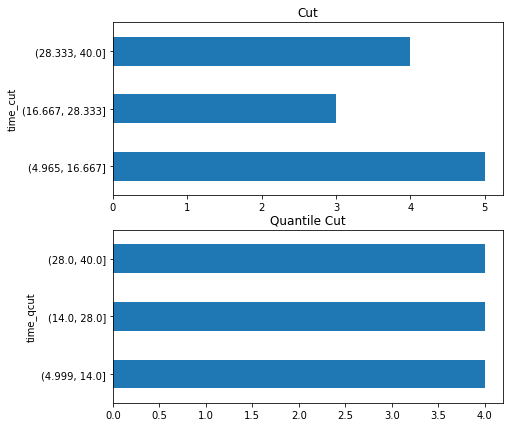

In [ ]:
# 시각화
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.title('Cut')
edu_time_df.groupby('time_cut').count().iloc[:, 0].plot(kind='barh');

plt.subplot(2, 1, 2)
plt.title('Quantile Cut')
edu_time_df.groupby('time_qcut').count().iloc[:, 0].plot(kind='barh');

### 🔨 상호작용 (Interaction)

> 다수의 feature를 결합하여서 새로운 feature를 만들어내는 방법이다. 다수의 feature가 서로 상호작용할 경우 feature를 각각 사용하는 것보다 결합하여 사용하는 것이 최종 예측에 도움이 된다.

1. 범주형 / 범주형 (Categorical / Categorical)
2. 수치형 / 수치형 (Numeric / Numeric)
3. 범주형 / 수치형 (Categorical / Numeric)

**⛔ 상세 예시 없음 ⛔**
> 데이터셋에 상호작용하는 feature가 없는 만큼, 상세 예시 없이 데이터셋에 존재하는 feature를 이용하여 상호작용 feature를 만드는 방법만 소개한다.


**유용한 자료**
- [Finding and Visualising Interactions - Towards Data Science](https://towardsdatascience.com/finding-and-visualising-interactions-14d54a69da7c)
- [How interaction terms are treated in Gradient Boosting? - StackExchange](https://stats.stackexchange.com/questions/427710/how-interaction-terms-are-treated-in-gradient-boosting)
- [Using Patsy for Statistical Modeling - Medium](https://medium.com/@mummertm/using-patsy-for-statistical-modeling-189a9d9f5d27)


#### 1. 범주형 / 범주형 (Categorical / Categorical)

> 범주형 간에 상호작용(interaction)일 경우 원핫 인코딩(One-Hot Encoding)을 한 후 결합한다.

- sklearn `OneHotEncoder`
- patsy `dmatrix`




##### sklearn `OneHotEncoder`

- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

- **feature 열 이름 결합 후 원핫 인코딩**
> `B|2`, `B|3`, `C|3`처럼 데이터에서 존재하지 않는 경우에 원핫 인코딩에서 제외된다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 범주형 feature 합치기
edu_interaction_df = edu_df.copy()
edu_interaction_df['user|content'] = edu_interaction_df.user.map(str) + '|' + edu_interaction_df.content.map(str)

# 원핫 인코딩
X = edu_interaction_df['user|content'].values.reshape(-1, 1)
enc = OneHotEncoder()
encoded = enc.fit_transform(X).toarray()

# 상호작용 원핫 인코딩
interaction_df = pd.DataFrame(encoded, columns=enc.categories_[0], dtype=np.int8)

pd.concat([edu_interaction_df, interaction_df], axis=1).iloc[:, [0, 1, 5, 6, 7, 8, 9, 10, 11]]

,user,content,user|content,A|1,A|2,A|3,B|1,C|1,C|2
0,A,1,A|1,1,0,0,0,0,0
1,A,2,A|2,0,1,0,0,0,0
2,A,3,A|3,0,0,1,0,0,0
3,A,1,A|1,1,0,0,0,0,0
4,A,2,A|2,0,1,0,0,0,0
5,B,1,B|1,0,0,0,1,0,0
6,B,1,B|1,0,0,0,1,0,0
7,C,1,C|1,0,0,0,0,1,0
8,C,2,C|2,0,0,0,0,0,1
9,C,1,C|1,0,0,0,0,1,0


- **feature 원핫 인코딩 후 결합**
> `B|2`, `B|3`, `C|3`처럼 데이터에서 존재하지 않아도 원핫 인코딩에 포함된다.

In [ ]:
edu_interaction_df = edu_df.copy()

# 원핫 인코딩
X_user = edu_interaction_df['user'].values.reshape(-1, 1)
X_content = edu_interaction_df['content'].values.reshape(-1, 1)

enc = OneHotEncoder()
encoded_user = enc.fit_transform(X_user).toarray()
encoded_content = enc.fit_transform(X_content).toarray()

# 두 원핫 인코딩 결과가 결합한 후의 index 구하기
interaction_i = len(encoded_content[0])*np.where(encoded_user == 1)[1] + np.where(encoded_content == 1)[1]

# interaction 열 이름 구하기
user_categories = edu_interaction_df['user'].unique()
content_categories = edu_interaction_df['content'].unique()

columns = []
for user_category in user_categories:
    for content_category in content_categories:
        columns.append(user_category + '|' + content_category)

# 원핫 인코딩
interaction = np.eye(9)[interaction_i]

pd.DataFrame(interaction, columns=columns, dtype=np.int8)

,A|1,A|2,A|3,B|1,B|2,B|3,C|1,C|2,C|3
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,1,0,0


##### patsy `dmatrix`

**patsy 기호**
- `+` - feature 추가
- `:` - 상호작용(interaction)
- `*` - 두 feature와 상호작용(interaction) 모두 표시
- `I()` - 수치 연산 적용
- `0` - Intercept 제거


- [patsy API reference - patsy 공식문서](https://patsy.readthedocs.io/en/latest/API-reference.html)

In [ ]:
from patsy import dmatrix 

edu_interaction_df = edu_df.copy()

interaction_df = dmatrix("content:user + 0", data=edu_interaction_df, return_type='dataframe')
interaction_df = interaction_df.astype(np.int8)

pd.concat([edu_interaction_df, interaction_df], axis=1).iloc[:, [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13]]

,user,content,content[1]:user[A],content[2]:user[A],content[3]:user[A],content[1]:user[B],content[2]:user[B],content[3]:user[B],content[1]:user[C],content[2]:user[C],content[3]:user[C]
0,A,1,1,0,0,0,0,0,0,0,0
1,A,2,0,1,0,0,0,0,0,0,0
2,A,3,0,0,1,0,0,0,0,0,0
3,A,1,1,0,0,0,0,0,0,0,0
4,A,2,0,1,0,0,0,0,0,0,0
5,B,1,0,0,0,1,0,0,0,0,0
6,B,1,0,0,0,1,0,0,0,0,0
7,C,1,0,0,0,0,0,0,1,0,0
8,C,2,0,0,0,0,0,0,0,1,0
9,C,1,0,0,0,0,0,0,1,0,0


#### 2. 수치형 / 수치형 (Numeric / Numeric)

> 수치형 feature 간에 연산($+ - \times \div$)을 하여 새로운 feature를 만든다

- pandas ($+ - \times \div$)
- sklearn `PolynomialFeatures` ($\times$)
- patsy `dmatrix` ($+ - \times \div$)

**⛔ content feature ⛔**
> 데이터셋에서 수치형 feature가 `time`밖에 없기에 임시로 `content`를 수치형으로 취급하여 사용한다.  


##### pandas ($+ - \times \div$)


In [ ]:
edu_interaction_df = edu_df.copy()

content = edu_interaction_df['content'].astype(np.int8).values
time = edu_interaction_df['time'].values

# + − × ÷
pd.DataFrame({'content': content,
              'time': time,
              'content+time': content+time,
              'content-time': content-time,
              'content*time': content*time,
              'content/time': content/time})

,content,time,content+time,content-time,content*time,content/time
0,1,22,23,-21,22,0.045455
1,2,19,21,-17,38,0.105263
2,3,27,30,-24,81,0.111111
3,1,15,16,-14,15,0.066667
4,2,11,13,-9,22,0.181818
5,1,33,34,-32,33,0.030303
6,1,10,11,-9,10,0.100000
7,1,30,31,-29,30,0.033333
8,2,40,42,-38,80,0.050000
9,1,35,36,-34,35,0.028571


##### sklearn `PolynomialFeatures` ($\times$)

- [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

edu_interaction_df = edu_df.copy()

X = edu_interaction_df[['content', 'time']]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

pd.DataFrame(X_poly, columns=poly.get_feature_names(), dtype=np.int8)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0,x1,x0 x1
0,1,22,22
1,2,19,38
2,3,27,81
3,1,15,15
4,2,11,22
5,1,33,33
6,1,10,10
7,1,30,30
8,2,40,80
9,1,35,35


##### patsy `dmatrix` ($+ - \times \div$)
**patsy 기호**
- `+` - feature 추가
- `:` - 상호작용(interaction)
- `*` - 두 feature와 상호작용(interaction) 모두 표시
- `I()` - 수치 연산 적용
- `0` - Intercept 제거


- [patsy API reference - patsy 공식문서](https://patsy.readthedocs.io/en/latest/API-reference.html)

In [ ]:
from patsy import dmatrix 

edu_interaction_df = edu_df.copy()
edu_interaction_df.content = edu_interaction_df.content.astype(np.int8)

# 상호작용 (:)은 I(*) 곱하기 연산과 결과가 동일하다
interaction_df = dmatrix("content + time + content:time + I(content+time) + I(content-time) + I(content*time) + I(content/time) + 0", data=edu_interaction_df, return_type='dataframe')
interaction_df.astype(np.int8)

,content,time,content:time,I(content + time),I(content - time),I(content * time),I(content / time)
0,1,22,22,23,-21,22,0
1,2,19,38,21,-17,38,0
2,3,27,81,30,-24,81,0
3,1,15,15,16,-14,15,0
4,2,11,22,13,-9,22,0
5,1,33,33,34,-32,33,0
6,1,10,10,11,-9,10,0
7,1,30,30,31,-29,30,0
8,2,40,80,42,-38,80,0
9,1,35,35,36,-34,35,0


#### 3. 범주형 / 수치형 (Categorical / Numeric)

> 범주형 feature를 원핫 인코딩(One-Hot Encoding)을 한 후 수치형 feature와 곱하여 결합한다.

- sklearn `OneHotEncoder`
- patsy `dmatrix`

##### sklearn `OneHotEncoder`

- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

edu_interaction_df = edu_df.copy()

X_user = edu_interaction_df['user'].values.reshape(-1, 1)
X_time = edu_interaction_df['time'].values.reshape(-1, 1)

# 원핫 인코딩
enc = OneHotEncoder()
encoded_user = enc.fit_transform(X_user).toarray()

# 상호작용
interaction = encoded_user * X_time
columns = enc.categories_[0] + '|time'

pd.DataFrame(interaction, columns=columns, dtype=np.int8)

,A|time,B|time,C|time
0,22,0,0
1,19,0,0
2,27,0,0
3,15,0,0
4,11,0,0
5,0,33,0
6,0,10,0
7,0,0,30
8,0,0,40
9,0,0,35


##### patsy `dmatrix`
**patsy 기호**
- `+` - feature 추가
- `:` - 상호작용(interaction)
- `*` - 두 feature와 상호작용(interaction) 모두 표시
- `I()` - 수치 연산 적용
- `0` - Intercept 제거


- [patsy API reference - patsy 공식문서](https://patsy.readthedocs.io/en/latest/API-reference.html)

In [ ]:
from patsy import dmatrix 

edu_interaction_df = edu_df.copy()
dmatrix("user:time + 0", data=edu_interaction_df, return_type='dataframe').astype(np.int8)

,user[A]:time,user[B]:time,user[C]:time
0,22,0,0
1,19,0,0
2,27,0,0
3,15,0,0
4,11,0,0
5,0,33,0
6,0,10,0
7,0,0,30
8,0,0,40
9,0,0,35


### 🔨 행렬 분해 (Matrix Factorization)

> 행렬을 두 개의 저차원 행렬로 분해하는 것을 말하며 추천 시스템을 공부하면 가장 흔하게 볼 수 있는 방법이다. 범주형 feature의 잠재 요인(latent factor)을 feature로 사용하고자 할 경우 이 잠재 요인(latent factor)을 가장 손쉽게 구할 수 있는 방법이 이 행렬 분해(Matrix Factorization)이다.

⭐행렬 분해 예시⭐
> 여기서는 정답 횟수를 행렬의 값으로 사용하였지만 문제별로 사용한 시간의 평균 혹은 다른 feature를 값으로 활용한다면 다른 잠재 요인 값들을 얻어낼 수 있다. 
- $R \approx PQ^{T}$
    - $R$ : 유저들에 대한 문제별 정답 횟수 행렬
    - $P$ : 유저와 잠재 요인의 행렬
    - $Q$ : 문제와 잠재 요인의 행렬


1. SVD (Singular Value Decomposition)
2. Truncated SVD
3. NMF (Non-negative Matrix Factorization)

**유용한 자료**
- [Understanding of Matrix Factorization (MF) and Singular Value Decomposition (SVD) - Medium](https://medium.com/analytics-vidhya/understanding-of-matrix-factorization-mf-and-singular-value-decomposition-svd-1a38c2d5bbaa)
- [Latent Matrix Factorization - Medium](https://medium.com/swlh/latent-matrix-factorization-6fa1cd0b2e5f)

#### 1. SVD (Singular Value Decomposition)

> 특이값 분해라고 불리며 행렬 분해에서 가장 보편적으로 많이 사용되는 방법이다.


⭐SVD 예시⭐
>  
- $R \approx U \Sigma V^{T}$
    - $R$ : 유저들에 대한 문제별 정답 횟수 행렬
    - $U$ : 유저와 잠재 요인의 행렬
    - $\Sigma$ : 잠재 요인의 중요도 행렬
    - $V$ : 문제와 잠재 요인의 행렬

- 유저별 각 문제 맞춘 횟수를 표현한 행렬 분해

**유용한 자료**
- [You Don’t Know SVD (Singular Value Decomposition) - Towards Data Science](https://towardsdatascience.com/svd-8c2f72e264f)

##### 유저들에 대한 문제별 정답 횟수 행렬 분해

> 유저가 각 문제를 맞춘 횟수를 활용하여 각 문제들의 잠재 요인에 대해 분석해보자

- [pandas.DataFrame.pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)
- [numpy.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)
- [numpy.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)



In [ ]:
edu_svd_df = edu_df.copy()

### 유저들에 대한 문제별 정답 횟수 행렬 만들기
# 이 작업은 pivot을 적용하기 위해 user와 content의 조합이 unique하게 만든다
edu_correct_df = edu_svd_df.groupby(['user', 'content']).correct.sum().reset_index()

# pivot을 적용하여 user * content 행렬 만들기
edu_pivot_df = edu_correct_df.pivot(index='user', columns='content', values='correct').fillna(0)

edu_pivot_df

content,1,2,3
user,,,
A,2.0,1.0,1.0
B,1.0,0.0,0.0
C,3.0,1.0,0.0


In [ ]:
from numpy.linalg import svd

U, sigma, VT = svd(edu_pivot_df)

# sigma의 경우에는 np.diag를 적용해줘야 대각 행렬이 나온다
U, np.diag(sigma), VT

(array([[-0.58333423,  0.80472284, -0.11019223],
        [-0.23139145, -0.29469003, -0.92715467],
        [-0.77857509, -0.51534351,  0.35810877]]),
 array([[4.01699236, 0.        , 0.        ],
        [0.        , 0.88589351, 0.        ],
        [0.        , 0.        , 0.28100722]]),
 array([[-0.92949771, -0.33903707, -0.14521666],
        [-0.26106399,  0.32665249,  0.90837423],
        [-0.26053715,  0.8822426 , -0.39213311]]))

In [ ]:
# 유저와 문제의 값 종류
users = edu_pivot_df.index.values
contents = edu_pivot_df.columns.values

# 유저 잠재 요인 - U
user_latent_factor = {}

# scaling
U = U @ np.diag(sigma)

for i, user in enumerate(users):
    user_latent_factor[user] = U[i]
    print(f'user {user} latent factor {U[i]}')

# 문제 잠재 요인 - V
content_latent_factor = {}

# scaling
VT = np.diag(sigma) @ VT

for i, content in enumerate(contents):
    content_latent_factor[content] = VT.T[i]
    print(f'content {content} latent factor {VT.T[i]}')

user A latent factor [-2.34324915  0.71289874 -0.03096481]
user B latent factor [-0.92949771 -0.26106399 -0.26053715]
user C latent factor [-3.12753019 -0.45653948  0.10063115]
content 1 latent factor [-3.73378518 -0.2312749  -0.07321282]
content 2 latent factor [-1.36190932  0.28937933  0.24791654]
content 3 latent factor [-0.58333423  0.80472284 -0.11019223]


In [ ]:
# 문제 잠재 요인들을 각 문제에 mapping
nested_content_lf = edu_svd_df['content'].map(content_latent_factor).values

# nested numpy array를 하나의 numpy array로 변환
content_lf = np.concatenate(nested_content_lf, 0).reshape(-1, 3)

# 문제 잠재 요인을 기존 pandas DataFrame에 추가
edu_svd_df[[f'content_lf{i + 1}' for i in range(3)]] = content_lf

edu_svd_df

,user,content,time,timestamp,correct,content_lf1,content_lf2,content_lf3
0,A,1,22,1.609508e+09,1,-3.733785,-0.231275,-0.073213
1,A,2,19,1.610026e+09,0,-1.361909,0.289379,0.247917
2,A,3,27,1.610116e+09,1,-0.583334,0.804723,-0.110192
3,A,1,15,1.610807e+09,1,-3.733785,-0.231275,-0.073213
4,A,2,11,1.610894e+09,1,-1.361909,0.289379,0.247917
5,B,1,33,1.611153e+09,0,-3.733785,-0.231275,-0.073213
6,B,1,10,1.611491e+09,1,-3.733785,-0.231275,-0.073213
7,C,1,30,1.611657e+09,0,-3.733785,-0.231275,-0.073213
8,C,2,40,1.611664e+09,1,-1.361909,0.289379,0.247917
9,C,1,35,1.611668e+09,1,-3.733785,-0.231275,-0.073213


#### 2. Truncated SVD

> SVD하고 원리가 동일하지만 중요한 K개의 잠재 요인만을 남기고 이외의 것들은 제거(truncate)한다는 점에서 차이가 있다.

    

- 유저별 각 문제 맞춘 횟수를 표현한 행렬 분해

##### 유저들에 대한 문제별 정답 횟수 행렬 분해

> SVD에서 한 것을 다시 한번 Trucated SVD로 분해해보자. SVD에서의 결과와 동일하지만 초기에 지정한 n개의 잠재 요인만 결과로 표시되는 것을 볼 수 있다.

- [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- `sklearn`의 TrucatedSVD는 $U \Sigma$의 결과만 표시한다.
- `numpy.linalg.svd`와 값은 동일해도 부호(sign)에서 차이가 날 수 있다. `sklearn`에 따르면 이를 SVD의 문제점 중 하나로 **sign indeterminacy**라고 부른다.


In [ ]:
edu_svd_df = edu_df.copy()

### 유저들에 대한 문제별 정답 횟수 행렬 만들기
# 이 작업은 pivot을 적용하기 위해 user와 content의 조합이 unique하게 만든다
edu_correct_df = edu_svd_df.groupby(['user', 'content']).correct.sum().reset_index()

# pivot을 적용하여 user * content 행렬 만들기
edu_pivot_df = edu_correct_df.pivot(index='user', columns='content', values='correct').fillna(0)

edu_pivot_df

content,1,2,3
user,,,
A,2.0,1.0,1.0
B,1.0,0.0,0.0
C,3.0,1.0,0.0


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)

# 유저의 잠재 요인 행렬
svd.fit(edu_pivot_df)
print('⭐ user latent factor\n', svd.transform(edu_pivot_df), end='\n\n')

# 문제의 잠재 요인 행렬
svd.fit(edu_pivot_df.T)
print('⭐ content latent factor\n', svd.transform(edu_pivot_df.T))

⭐ user latent factor
 [[ 2.34324915  0.71289874]
 [ 0.92949771 -0.26106399]
 [ 3.12753019 -0.45653948]]

⭐ content latent factor
 [[ 3.73378518 -0.2312749 ]
 [ 1.36190932  0.28937933]
 [ 0.58333423  0.80472284]]


#### 3. NMF (Non-negative Matrix Factorization)

> SVD와는 다르게 분해한 행렬에 음수값이 없는 행렬분해 방법이다.

- 유저별 각 문제를 푼 시간을 표현한 행렬 분해

##### 유저별 각 문제를 푼 시간을 표현한 행렬 분해

- [sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

In [ ]:
edu_nmf_df = edu_df.copy()

### 유저들에 대한 문제별 사용 시간 행렬 만들기
# 이 작업은 pivot을 적용하기 위해 user와 content의 조합이 unique하게 만든다
edu_time_df = edu_nmf_df.groupby(['user', 'content']).time.sum().reset_index()

# pivot을 적용하여 user * content 행렬 만들기
edu_pivot_df = edu_time_df.pivot(index='user', columns='content', values='time').fillna(0)

edu_pivot_df

content,1,2,3
user,,,
A,37.0,30.0,27.0
B,43.0,0.0,0.0
C,82.0,40.0,0.0


In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)

# 유저의 잠재 요인 행렬
nmf.fit(edu_pivot_df)
print('⭐ user latent factor\n', nmf.transform(edu_pivot_df), end='\n\n')

# 문제의 잠재 요인 행렬
nmf.fit(edu_pivot_df.T)
print('⭐ content latent factor\n', nmf.transform(edu_pivot_df.T))

⭐ user latent factor
 [[3.72501189 5.40237629]
 [3.88281241 0.        ]
 [8.59237686 0.95010586]]

⭐ content latent factor
 [[9.54036412 0.        ]
 [3.40927819 3.63285041]
 [0.         5.25681232]]


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


### 🔨 차원 축소 (Dimension Reduction)

> 차원 축소는 고차원의 데이터를 정보 손실을 가능한 줄이며 저차원의 공간으로 투영하는 것을 말하며 차원의 저주(curse of dimensionality)를 방지하는 목적을 가지고 있다. **쉽게 말하면 100개의 feature로 표현하는 정보를 10개의 feature로 표현하고 싶을 때, 단순히 90개의 feature를 제거하는 것이 아니라 100개의 feature를 가능한 잘 대변하는 10개의 feature를 새롭게 만들어내는 것이다.**<br><br>
feature의 갯수를 줄이고 싶을 때 특성 선택(feature selection)을 사용하기도 하지만 특성 추출(feature extraction)방법을 사용하기도 하며 이 특성 추출(feature extraction)방법 중 하나가 차원 축소(dimension reduction)이다.  

1. PCA (Principal Component Analysis)
2. LDA (Linear Discriminant Analysis)
3. LDA (Latent Dirichlet Allocation)


**유용한 자료**
- [What is dimensionality reduction? What is the difference between feature selection and extraction? - StackExchange](https://datascience.stackexchange.com/questions/130/what-is-dimensionality-reduction-what-is-the-difference-between-feature-selecti)
- [Feature Extraction - Wikipedia](https://en.wikipedia.org/wiki/Feature_extraction)
- [Dimensionality Reduction(PCA and LDA) with Practical Implementation - Medium](https://medium.com/machine-learning-researcher/dimensionality-reduction-pca-and-lda-6be91734f567)



#### 1. PCA (Principal Component Analysis)

> PCA는 데이터셋의 분산이 최대가 되도록 하는 주성분(Principal Component)을 찾아 이를 사용하여 고차원 데이터를 투영함으로서 저차원 데이터로 변환한다. 주성분은 SVD를 사용하여 손쉽게 구할 수 있다. 

- 유저들에 대한 문제별 정답 횟수 행렬 PCA
- 시간과 연관된 feature들의 PCA


##### 유저들에 대한 문제별 정답 횟수 행렬 PCA

> 행렬 분해에서처럼 유저와 문제별 행렬을 만들어 차원 축소를 진행한다. 실제 대회에서 사용되는 방법이다. 여기서는 pandas의 pivot대신 unstack를 사용하여서 행렬을 생성하였다. PCA에서는 SVD와 값이 어떻게 달라지는지 살펴보자.

- [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [pandas.DataFrame.unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html)

In [ ]:
edu_pca_df = edu_df.copy()

### 유저들에 대한 문제별 정답 횟수 행렬 만들기
edu_pca_df = edu_pca_df.groupby(['user', 'content'])['correct'].sum()
edu_pca_df = edu_pca_df.astype(np.uint8)
edu_pca_df = edu_pca_df.unstack(fill_value=0)

edu_pca_df

content,1,2,3
user,,,
A,2,1,1
B,1,0,0
C,3,1,0


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# 유저의 문제별 정답 횟수에 대한 차원 축소 
pca.fit(edu_pca_df)
print('⭐ user PCA\n', pca.transform(edu_pca_df), end='\n\n')

# 문제의 유저별 정답 횟수에 대한 차원 축소 
pca.fit(edu_pca_df.T)
print('⭐ content PCA\n', pca.transform(edu_pca_df.T))

⭐ user PCA
 [[-0.21633189  0.71327138]
 [ 1.22135608 -0.25267545]
 [-1.00502418 -0.46059593]]

⭐ content PCA
 [[ 1.91353317 -0.07111597]
 [-0.51272967  0.26540841]
 [-1.4008035  -0.19429244]]


##### 시간과 연관된 feature들의 PCA

> 데이터셋에서 `time, timestamp` feature를 활용하여 필요한 feature들을 추가하고 여기에 PCA를 적용해보자. 여기서는 예시를 위해 2개의 feature만 이용하였지만 feature가 많을 때 적용해야 효과적이다.

- [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [ ]:
edu_time_df = edu_df.copy()

# 유저 문제를 푼 시간을 feature로 추가
edu_time_df['hour'] = edu_time_df['timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

# 시간 관련 feature
X = edu_time_df[['time', 'hour']]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
edu_time_df['time_pca'] = pca.fit_transform(X)
edu_time_df[['time', 'hour', 'time_pca']]

,time,hour,time_pca
0,22,13,0.412978
1,19,13,-2.586703
2,27,14,5.397869
3,15,14,-6.600856
4,11,14,-10.600431
5,33,14,11.397231
6,10,12,-11.571169
7,30,10,8.455861
8,40,12,18.425643
9,35,13,13.411597


#### 2. LDA (Linear Discriminant Analysis)

> PCA가 전체 데이터셋의 분산이 최대가 되는 것을 목적으로 한다면, LDA는 각 클래스로 데이터셋을 나눠 분산을 고려한다. 각 클래스 내의 분산은 최소가 되고 클래스 간의 거리가 최대가 되도록 고차원 데이터를 저차원 데이터로 변환한다.

- 시간과 연관된 feature들의 LDA



##### 시간과 연관된 feature들의 LDA

> LDA에서는 PCA와 값이 어떻게 달라지는지 살펴보자.

- [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

In [ ]:
edu_time_df = edu_df.copy()

# 유저 문제를 푼 시간을 feature로 추가
edu_time_df['hour'] = edu_time_df['timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

# 시간 관련 feature
X = edu_time_df[['time', 'hour']]
y = edu_time_df[['correct']]

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)

edu_time_df['time_lda'] = lda.fit_transform(X, y)
edu_time_df[['time', 'hour', 'correct', 'time_lda']]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,time,hour,correct,time_lda
0,22,13,1,0.037572
1,19,13,0,0.270156
2,27,14,1,-0.070566
3,15,14,1,0.859769
4,11,14,1,1.169880
5,33,14,0,-0.535733
6,10,12,1,0.688405
7,30,10,0,-1.421155
8,40,12,1,-1.637431
9,35,13,1,-0.970290


#### 3. LDA (Latent Dirichlet Allocation)

> 토픽 모델링(Topic Modeling)에 속하는 비지도 학습 모델로 문서를 자신이 지정한 K개의 주제(Topic) 중 하나로 분류하기 위해 사용된다. 여기서는 각 고차원 데이터(원래라면 문서)의 K개의 주제(Topic) 비율을 알아내어 이를 저차원 데이터로 사용한다. 

⛔ LDA의 이중성 ⛔
> 잠재 디리클레 할당(Latent Dirichlet Allocation)과 선형 판별 분석(Linear Discriminant Analysis)은 같은 LDA 약자를 가지지만 다른 방법론이다. LDA라는 약자를 글에서 보게되면 어떤 LDA인지 파악하여야 한다.

- 문제들에 대한 유저별 정답 횟수 행렬 LDA

**유용한 자료**
- [A Beginner’s Guide to Latent Dirichlet Allocation(LDA) - Towards Data Science](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)
- [Topic Modeling, LDA - ratsgo's blog](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/)

##### 문제들에 대한 유저별 정답 횟수 행렬 LDA

> LDA를 적용할 경우 문제를 유저들의 정답 횟수 정보를 이용하여 K개의 주제(Topic)로 분류하는 것이며 각 문제의 K개의 주제에 대한 확률이 곧 문제를 대표하는 저차원 데이터로 사용된다.
- 문서 : 문제
- 단어 : 유저
- 단어 출현 횟수 : 정답 횟수

- [sklearn.decomposition.LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.*LatentDirichletAllocation*)

In [ ]:
edu_lda_df = edu_df.copy()

### 문제들에 대한 유저별 정답 횟수 행렬 만들기
edu_lda_df = edu_lda_df.groupby(['content', 'user'])['correct'].sum()
edu_lda_df = edu_lda_df.astype(np.uint8)
edu_lda_df = edu_lda_df.unstack(fill_value=0)

edu_lda_df

user,A,B,C
content,,,
1,2,1,3
2,1,0,1
3,1,0,0


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=2)

# 문제의 잠재 디리클레 할당
lda.fit(edu_lda_df)
print('⭐ content LDA\n', lda.transform(edu_lda_df), end='\n\n')

# 유저의 잠재 디리클레 할당 
lda.fit(edu_lda_df.T)
print('⭐ user LDA\n', lda.transform(edu_lda_df.T))

⭐ content LDA
 [[0.89007599 0.10992401]
 [0.70374888 0.29625112]
 [0.30848894 0.69151106]]

⭐ user LDA
 [[0.42727114 0.57272886]
 [0.27254038 0.72745962]
 [0.11942516 0.88057484]]


### 🔨 임베딩 (Embedding)

> feature를 특정 길이의 벡터로 표현하는 방법으로 인코딩(encoding)과는 다르게 임베딩(embedding)된 벡터는 관계, 맥락이나 의미와 같은 정보를 담고 있다.

1. 카테고리 임베딩 (Categorical Embedding)
2. Word2Vec

**유용한 자료**
- [Embedding - 구글 머신러닝 단기집중과정](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture?hl=ko)
- [Word Embedding and One Hot Encoding - Medium](https://medium.com/intelligentmachines/word-embedding-and-one-hot-encoding-ad17b4bbe111)
- [One Hot Encoding vs Word Embeding - When to choose one or another? - StackExchange](https://datascience.stackexchange.com/questions/29851/one-hot-encoding-vs-word-embeding-when-to-choose-one-or-another)

#### 1. 카테고리 임베딩 (Categorical Embedding)

> 범주형(categorical) feature를 특정 길이의 벡터로 임베딩하는 것이다. 예로 트랜스포머(Transformer)에서 단어 혹은 카테고리(category)들을 임베딩(embedding) 할 때 자주 사용된다. 신경망을 통해 훈련시켜야 하며 훈련된 임베딩 행렬을 활용하여 임베딩된 새로운 feature를 만들어낼 수 있다.

- [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

**유용한 자료**
- [Categorical Embedding and Transfer Learning - Towards Data Science](https://towardsdatascience.com/categorical-embedding-and-transfer-learning-dd3c4af6345d)

#### 2. Word2Vec

> 자연어 처리에서 사용되며 문장의 단어를 임베딩 하는 방법으로 주변 단어와의 관계를 단어의 벡터로 표현하는 방법이다. 대회에서 단어가 아닌 범주형 feature를 word2vec을 이용하여 임베딩(embedding)하기도 한다. 기존에 존재하거나 만들어진 feature에 적용할 수 있으며 중요한 것은 문장에서의 단어처럼 해당 feature 내부의 데이터 간의 순서가 중요할 경우 word2vec을 사용할 수 있다.

- 문제를 word2vec을 적용하여 임베딩

**유용한 자료**
- [Introduction to Word Embedding and Word2Vec - Towards Data Science](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [Is word embedding a form of feature extraction? - StackExchange](https://ai.stackexchange.com/questions/17273/is-word-embedding-a-form-of-feature-extraction)

##### 문제를 word2vec을 적용하여 임베딩

> 주어진 데이터셋의 문제(content) feature에 word2vec을 적용해보자. 문장과 단어를 다음처럼 가정하면 된다.
- 문장 (sentence) : 유저
- 단어 (word) : 문제

- [gensim.models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [ ]:
edu_emb_df = edu_df.copy()

# 유저별 문제들을 리스트로 변환하기
edu_list_df = edu_emb_df.groupby('user')['content'].apply(list)
edu_list_df

user
A    [1, 2, 3, 1, 2]
B             [1, 1]
C    [1, 2, 1, 1, 1]
Name: content, dtype: object

In [ ]:
# 문장 : 유저(user)
# 단어 : 문제(content)
sentences = list(edu_list_df.values)
sentences

[['1', '2', '3', '1', '2'], ['1', '1'], ['1', '2', '1', '1', '1']]

In [ ]:
from gensim.models import Word2Vec

# 모델 훈련
# vector_size : 각 단어의 임베딩 벡터 크기
# window : 훈련에 고려할 주변 단어의 수
# min_count : 최소 단어 빈도수로 특정 빈도수 이하면 무시
# sg : 0 - CBOW, 1 - skip gram
model = Word2Vec(sentences, vector_size=2, window=3, min_count=1, sg=1)

**시각화**
- [matplotlib.pyplot.scatter](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.pyplot.scatter.html) : 점 표시
- [matplotlib.pyplot.arrow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.arrow.html) : 화살표 표시
- [matplotlib.pyplot.axvline](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.axvline.html) : y축 표시
- [matplotlib.pyplot.axhline](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.axhline.html) : x축 표시
- [matplotlib.pyplot.xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim.html) : x축 기준 그래프 시각화 영역 한정
- [matplotlib.pyplot.ylim](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html) : y축 기준 그래프 시각화 영역 한정

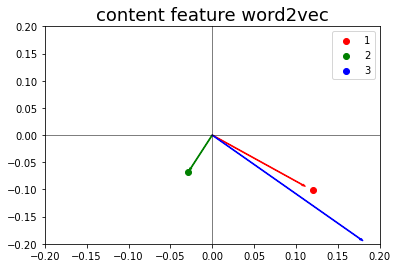

In [ ]:
# 시각화
colors = ['r', 'g', 'b']
for content, color in zip(model.wv.index_to_key, colors):
    vector = model.wv.get_vector(content)
    
    # 점 표시
    plt.scatter(*vector, label=content, color=color)
    
    # scaling
    vector = vector * 0.9

    # 화살표
    plt.arrow(0, 0, *vector, color=color)

plt.axvline(x=0, color='k', lw='1', alpha=0.5)
plt.axhline(y=0, color='k', lw='1', alpha=0.5)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.title('content feature word2vec', size=18)
plt.legend();

In [ ]:
# 임베딩 정보
content2vec = {}
for content in model.wv.index_to_key:
    content2vec[content] = model.wv.get_vector(content)

content2vec

{'1': array([ 0.11993884, -0.10172551], dtype=float32),
 '2': array([-0.02851091, -0.06773666], dtype=float32),
 '3': array([ 0.19684076, -0.2125894 ], dtype=float32)}

In [ ]:
# 문제 임베딩 값들을 각 문제에 mapping
nested_content2vec = edu_emb_df.content.map(content2vec).values

# nested numpy array를 하나의 numpy array로 변환
content2vec_array = np.concatenate(nested_content2vec, 0).reshape(-1, 2)

# 문제 임베딩 값들을 기존 pandas DataFrame에 추가
edu_emb_df[[f'content2vec_{i + 1}' for i in range(2)]] = content2vec_array

### 🔨 외부 데이터 활용 (Data Enrichment)

> 주어진 데이터 뿐만 아니라 외부 데이터를 활용하여 데이터를 더욱 풍요롭게 만드는 방법이다. 

1. 유사한 데이터셋 활용
2. 외부 데이터를 이용하여 새로운 feature 생성

⛔ **주의사항** ⛔
1. 대회에 참여하고 있다면 외부 데이터를 활용 가능한지 꼼꼼히 규정을 체크하고 허용된다 하더라도 돌다리도 두들겨보는 심정으로 대회 주최자들에게 문의하여 사용가능 여부를 체크하자
    - 500,000$ 상금을 놓친 사례
        - [1st Place Removed Solution - Kaggle Deepfake Detection Challenge](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/157983)
        - [관련된 페이스북 포스팅 - 캐글 코리아](https://www.facebook.com/groups/KaggleKoreaOpenGroup/permalink/677319223000180/)
2. 활용하고자 하는 외부 데이터의 라이센스를 체크하자


#### 1. 유사한 데이터셋 활용

> 현재 사용하고 있는 데이터셋과 매우 유사한 목적을 가진 데이터셋을 가져와 훈련에 사용하는 방법이다.


#### 2. 외부 데이터를 이용하여 새로운 feature 생성

> 범주형 feature가 있을때 사용한다. 예로 주어진 데이터셋에 책의 장르가 있지만 그 외 어떤 책과 관련된 정보가 없다고 하자. 이럴 경우 외부 데이터를 활용하여 각 장르별 판매 수, 평균 가격, 작가 수, 평균 페이지 수 등의 데이터를 모아 새로운 feature로 활용할 수 있다.

**유용한 자료**
- [The Strategy That Increases Model Accuracy, Every Time, Guaranteed - Medium](https://medium.com/analytics-vidhya/the-strategy-that-increases-model-accuracy-every-time-guaranteed-6ee5e476262d)
- [External Geospatial Data: Types and Use-cases - Medium](https://medium.com/locale-ai/external-geospatial-data-types-and-use-cases-46d54756dc10)
- [Is it in general helpful to add “external” datasets to the training dataset? - StackExchange](https://stats.stackexchange.com/questions/474621/is-it-in-general-helpful-to-add-external-datasets-to-the-training-dataset)


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

